# Lesson 1: Practical Deep Learning for Coders

This notebook presents my personal notes and work coming from my experience with the first lesson of the course "**Practical Deep Learning**" by Jeremy Howard ([here](https://www.youtube.com/watch?v=8SF_h3xF3cE) for the video on YT) and the related fastbook, a Jupyter-Book from fast.ai. The lecture is based on the first chapter fo the book. 

Lesson structure:
- Is it a bird?  (See the original [Kaggle notebook](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data))
- How is is possibile? Classical ML approach for Image Recognition versus Deep-Learning;
- How to learn?
- What can deep-learning do now?
- Image-based approach for other tasks;
- Image Segmentation, Tabular data and collaborative systems for recommandation systems;
- Why pytorch and fastai?
- Classical coding vs Machine Learning;
- Homeworks.

In [1]:
# Uncomment to install the necessary packages  
# !pip install -r requirements.txt

## Is it a bird?

Jeremy kicks off his first lecture by diving straight into a cool example of deep learning, making the course hands-on right from the get-go. From the fastbook:
> "The basic idea is to teach the whole game. That means that if you're teaching baseball, you first take people to a baseball game or get them to play it. You don't teach them how to wind twine to make a baseball from scratch, the physics of a parabola, or the coefficient of friction of a ball on a bat."

Basically, he wants to highlight that back in 2015, the idea of making a computer recognize birds was so tricky that it became the punchline of an XKCD joke, shown here:

<div style="text-align:center">
<img src="./images/tasks_2x.png" width="200" height="100">
</div>
But guess what? Nowadays, we can pull off that same bird recognition in just a few minutes using totally free resources! In the world of CS, it's often hard to tell what's a walk in the park and what's nearly impossible. What seemed like a big challenge in 2015 can now be done with a few lines of code, and this lesson spills the beans on why and how it became possible.

The basic steps are:

1. Use DuckDuckGo to search for images of "bird photos";
2. Use DuckDuckGo to search for images of "forest photos", as a representative of not-bird photos;
3. Fine-tune a pretrained neural network to recognise these two groups;
4. Try running this model on a picture of a bird and see if it works.

### Step 1: Download images of birds and non-bird

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import L

def search_images(term, max_images=30):
    # Define a function to download from ddg a max of max_images with the keyword term
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search

In [3]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


C:\Users\conti\Progetti\agile-lab\books\fastbook\.venv\lib\site-packages\duckduckgo_search\compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


'https://images.pexels.com/photos/1661179/pexels-photo-1661179.jpeg?cs=srgb&dl=green-bird-1661179.jpg&fm=jpg'

...and then download a URL and take a look at it:

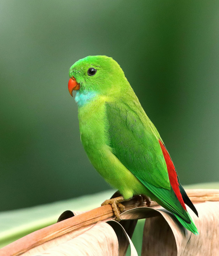

In [4]:
# download the image and save it in the dest provided
from fastdownload import download_url
dest = r'.\images\bird.jpg'
download_url(urls[0], dest, show_progress=False)

# load the image in the Image object from fastai.vision and show it
from fastai.vision.all import Image
im = Image.open(dest)
im.to_thumb(256,256)

As you may already know, a digital image consists of pixel with numerical value encoding colours or intensity, depending on the encoding technic adopted. You can practice with this concept with the web-app [PixSpy](https://pixspy.com/) as reported in the following image:

<div style="text-align:center">
<img src="./images/pixspy.PNG"  width="500" height="250">
</div>


As it could be hard to search for "not bird images" on a search engine, to get image in this example Jeremy is going to take images of forest. Hence, the following example is building a "bird/forest" classifier.
So let's do the same with "forest photos":

Searching for 'forest photos'


C:\Users\conti\Progetti\agile-lab\books\fastbook\.venv\lib\site-packages\duckduckgo_search\compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


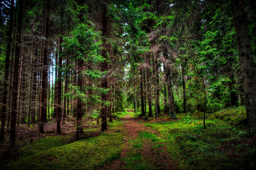

In [5]:
# download a forest image and show it
download_url(search_images('forest photos', max_images=1)[0], r'.\images\forest.jpg', show_progress=False)
Image.open(r'.\images\forest.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [6]:
from time import sleep
from pathlib import Path
from fastai.vision.all import download_images, resize_images
searches = 'forest','bird'
path = Path('bird_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [7]:
from fastai.vision.all import verify_images, get_image_files
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

8

### Step 2: Train our model

To train a model, we'll need DataLoaders, which is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model, not used during training).

In fastai you can create that easily using a DataBlock, and view sample images from it.

Here what each of the DataBlock parameters means:
```
blocks=(ImageBlock, CategoryBlock),
```
The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").
```
get_items=get_image_files, 
```
To find all the inputs to our model, run the get_image_files function (which returns a list of all image files in a path).
```
splitter=RandomSplitter(valid_pct=0.2, seed=42),
```
Split the data into training and validation sets randomly, using 20% of the data for the validation set.
```
get_y=parent_label,
```
The labels (y values) is the name of the parent of each file (i.e. the name of the folder they're in, which will be bird or forest).
```
item_tfms=[Resize(192, method='squish')]
```
Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).


C:\Users\conti\Progetti\agile-lab\books\fastbook\.venv\lib\site-packages\fastai\torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


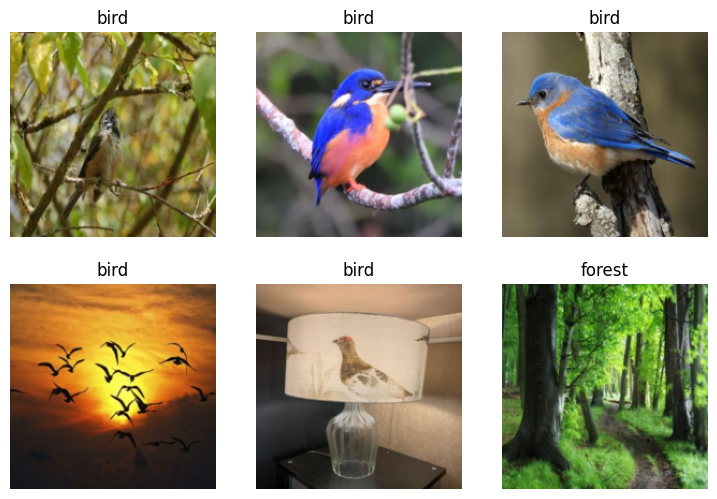

In [8]:
from fastai.vision.all import DataBlock, ImageBlock, CategoryBlock, RandomSplitter, parent_label, Resize

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Now we're ready to train our model. The fastest widely used computer vision model is resnet18. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

To train a model in fastai we need to define a learner, here we are using a vision learner from fastai.vision. When defining a lerner, we should specify:

- Data: in this case, we are using the DataBlock;
- Model: we are using resnet18, a well known CNN architecture;
- Metrics to check how the model is learning.

In this notebook, we are going to use tranfer-learning, an useful approach that consist in starting our task with a NN built for another task. In particular, fast-ai will use automatically a version of resnet18 weights trained to recognise photos in imagenet, and widely-used computer vision dataset with images covering 1000 categories).. Indeed, in the next cell you can see 

>"Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth"

when you define the learner.
Further, fastai comes with a helpful fine_tune() method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

timm image model...
https://github.com/fastai/timmdocs/tree/master/

Downloading resnet18 weight (trained on ImageNet) online available 

In [9]:
from fastai.vision.all import vision_learner, resnet18, error_rate
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.294794,0.337516,0.187500,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.172084,0.029756,0.000000,00:19
1,0.109352,0.007336,0.000000,00:24
2,0.071714,0.012011,0.000000,00:24


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).


### Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [10]:
from fastai.vision.all import PILImage
is_bird,_,probs = learn.predict(PILImage.create(r'.\images\bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


Good job, resnet18!

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"! All on your personal computer!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including creating amazing artworks, and explaining jokes. It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

## How is is possibile? Classical ML approach for Image Recognition versus Deep-Learning

Why are we able to build a bird recognizer in a minute? How was it done before?

In 2012, image recognition with classic machine learning (pre-deep learning) required deep knowledge and expertise in specific areas. For example, Jeremy presented a work from Harvard University that used machine learning for breast cancer detection from medical imaging. This kind of work demanded contributions from computer scientists, mathematicians, and pathologists. A considerable amount of time, expertise, and code were necessary to build features representative of that kind of problem, as illustrated in the following diagram

<div style="display:flex; justify-content:center; align-items:center;">
    <img src="./images/classicML_01.PNG"  width="400" height="200" style="margin: 10px;">
    <img src="./images/classicML_02.PNG"  width="400" height="200" style="margin: 10px;">
</div>

In contrast, deep learning automatically builds features for us. As demonstrated below, the first layer (i.e., neuron block) of a neural network extracts information from the original image related to horizontal, vertical, and oblique edges.

<p align="center">
  <img width="200" height="100" src="./images/nn_firstlayer.PNG"  style="margin: 10px;">
</p>

Deep learning is termed "deep" because it combines these features in more blocks. The features above are combined and processed with another bank of filters to obtain different and more complex representations, as shown in the second layer and so forth.

<p align="center">
  <img width="500" height="250" src="./images/nn_secondlayer.PNG"  style="margin: 10px;">
</p>

<p align="center">
  <img width="600" height="300" src="./images/nn_thirdlayer.PNG"  style="margin: 10px;">
</p>

## How to learn?
The course and the fastbook belive in the concept of "learning with context".
Jeremy will follow a practical and top-down approach, as people learn naturally (better) with context rather than by theoretical curriculum.
The key principles of the fastbook and the course:

- Teaching the whole game. We'll start by showing how to use a complete, working, very usable, state-of-the-art deep learning network to solve real-world problems, using simple, expressive tools. And then we'll gradually dig deeper and deeper into understanding how those tools are made, and how the tools that make those tools are made, and so on;
- Always teaching through examples. We'll ensure that there is a context and a purpose that you can understand intuitively, rather than starting with algebraic symbol manipulat- n- .
Simplifying as much as possible. We've spent years building tools and teaching methods that make previously complex topics very simple;
- Removing barriers. Deep learning has, until now, been a very exclusive game. We're breaking it open, and ensuring that everyone can play.


Do we need a lot of maths, a lot of data and a lot of computer resources? No! Real world problems can be dealt with few resources. 

| Myth (don't need) | Truth |
|---|---|
| Lots of math | Just high school math is sufficient |
| Lots of data | We've seen record-breaking results with <50 items of data |
| Lots of expensive computers | You can get what you need for state-of-the-art work for les|====

To complete the last point of the table, you can do real state-of-the-art work using free cloud services as Kaggle or Google Colab.

## What can deep learning do now?
- Image generation: from text input to images (DALL-E 2, midjourney);
- LLM: ChatGPT, language models can already explain jokes;
  
In this course you can get the practical basis to understand and work with this system!

Here's a list of some of the thousands of tasks in different areas at which deep learning, or methods heavily using deep learning, is now the best in the world:

- Natural language processing (NLP): Answering questions, speech recognition, summarizing documents, classifying documents, finding names or dates, etc. in documents, searching for articles mentioning a concept;
- Computer vision: Satellite and drone imagery interpretation (e.g., for disaster resilience), face recognition, image captioning, reading traffic signs, locating pedestrians and vehicles in autonomous vehicles;
- Medicine: Finding anomalies in radiology images, counting features in pathology slides, measuring features in ultrasounds, diagnosing diabetic retinopathy;
- Biology: Folding proteins, classifying proteins, genomics tasks, analyzing protein/protein interactions;
- Recommendation systems: Web search, product recommendations, home page layout;
- Playing games: Chess, Go, most Atari video games, and many real-time strategy games;
- Robotics: Handling objects that are challenging to locate (e.g., transparent, shiny, lacking texture) or hard to pick up;
- Other applications: Financial and logistical forecasting, text to speech, and much more...

## Image-base approach for other tasks

Many students of this course have started personal project. Many of them employed image-based representation to deal with other tasks, as:

1. Classify Sounds: Transforming Audio into Images

Innovative approaches in sound classification involve leveraging the power of images by representing sounds as spectrograms. Spectrograms provide a visual representation of the frequency content of audio signals over time. 

2. Classify Time-Series Using Image Representation

Time-series data, typically represented as sequences of numerical values over time, can be transformed into images to benefit from image-based approaches. Converting time-series data into visual patterns enables the application of convolutional neural networks (CNNs) and other image-based models for tasks such as classification.

3. Analyzing Mouse Movements with Splunk Module

<p align="center">
  <img width="500" height="250" src="./images/mouse.PNG"  style="margin: 10px;">
</p>


The interaction between users and digital interfaces, such as mouse movements, can be visualized as a series of images. A student integrated this module in Splunk, which is designed for analyzing machine-generated data. The image-based approach allows for the application of computer vision techniques to understand user behavior and identify patterns.

These image-based methodologies extend the application of visual representation beyond traditional computer vision tasks, showcasing the versatility of leveraging images for diverse data types and domains.

## Image Segmentation, Tabular data and collaborative systems for recommandation systems

As already seen, deep-learning is used in a lot of tasks, as we will show here.

- **Image Segmentation**
Creating a model that can recognize the content of every individual pixel in an image is called segmentation. Here is how we can train a segmentation model with fastai. 

<p align="center">
  <img width="300" height="150" src="./images/segmentation.PNG"  style="margin: 10px;">
</p>

- **Tabular Data**
Data in the form of a table, such as from a spreadsheet, database, or CSV files. You can see an example below. For this structured data,  columns can be categorical (i.e. contain values that are one of a discrete set of choices, such as occupation) and which are continuous (i.e. contain a number that represents a quantity, such as age). A task for this kind of data could be to a build a model that will predict whether a person is a high-income earner.

<p align="center">
  <img width="500" height="250" src="./images/tabular_data.PNG"  style="margin: 10px;">
</p>

- **Recommendation systems**
Recommendation systems are very important, particularly in e-commerce. Companies like Amazon and Netflix try hard to recommend products or movies that users might like. Here an example concerning movies: maybe we could be interested in training a model that will predict movies people might like, based on their previous viewing habits. 

<p align="center">
  <img width="200" height="100" src="./images/rec_movie.PNG"  style="margin: 10px;">
</p>

## Why fastai and why pytorch?

n this course, Jeremy is going to use PyTorch and fastai. But why this stack and not another one, such as Keras and TensorFlow?

PyTorch is designed to be a strong foundation to build on top of, and fastai is built on top of it, allowing the development of deep-learning models with a low-code approach. Indeed, the more code there is, the more mistakes can occur. Additionally, when a data scientist has to write a lot of code, it is obvious that there is less time for best practices and difficulty in maintenance. Fastai incorporates best practices for us and is highly popular in the industry.

Nowadays, PyTorch is the most used deep learning framework, as shown in the graph be
low.
<p align="center">
  <img width="400" height="200" src="./images/pytorch_tf.PNG"  style="margin: 10px;">
</p>

## Classical coding vs Machine Learning

Our bird recognizer is a deep learning model, a modern area in the more general discipline of machine learning that uses Neural Networks. But what is Machine Learning?

Machine learning is, like regular programming, a way to get computers to complete a specific task. But how would we use regular programming to do what we just did? We would have to write down for the computer the exact steps necessary to complete the task.

Normally, it's easy enough for us to write down the steps to complete a task when we're writing a program. We just think about the steps we'd take if we had to do the task by hand, and then we translate them into code. For instance, we can write a function that sorts a list. In general, we'd write a function that looks something like **basic_program** (where inputs might be an unsorted list, and results a sorted list).

Let's see what is a basic_program.

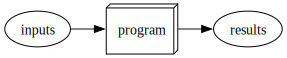

In [11]:
# you need graphviz installed on your machine, in Windows you can have problems, try to install graphviz and
# add it to the environ PATH
import os
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"
from fastbook import gv
gv('''program[shape=box3d width=1 height=0.7]
inputs->program->results''')

Now, lets see what a machine learning system is:

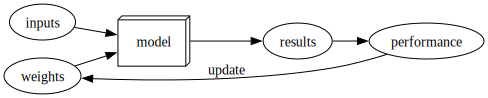

In [12]:
gv('''ordering=in
model[shape=box3d width=1 height=0.7]
inputs->model->results; weights->model; results->performance
performance->weights[constraint=false label=update]''')

Other elements in the scene are noticeable:

- Weights: a machine learning model is typically defined by a set of parameters, which significantly influence its functionality.
- Model: in this context, the program is more accurately termed a 'model.'
- Performance: the model executes its task, demonstrating a level of performance evaluated by a specific metric.
- Update: depending on the model's performance, the weights can be adjusted to enhance the overall effectiveness of the system.

In the context of deep-learning we have a slightly different jargon:

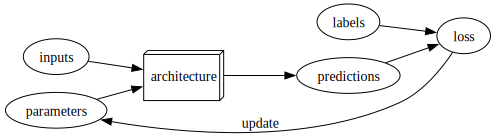

In [13]:
#hide_input
#caption Detailed training loop
#id detailed_loop
gv('''ordering=in
model[shape=box3d width=1 height=0.7 label=architecture]
inputs->model->predictions; parameters->model; labels->loss; predictions->loss
loss->parameters[constraint=false label=update]''')

- The functional form of the model is called its architecture (but be careful—sometimes people use model as a synonym of architecture, so this can get confusing).
- The weights are called parameters.
- The predictions are calculated from the independent variable, which is the data not including the labels.
- The results of the model are called predictions.
- The measure of performance is called the loss.
- The loss depends not only on the predictions, but also the correct labels (also known as targets or the dependent variable); 

## Homeworks

Run notebooks, especially the bird notebook. Create something interesting to you based on the bird notebook. Read the first chapter of the book. Be inspired by all the amazing student projects.

### Pizza classifier

I am going to utilize the same code as the bird recognizer, but for a new task to enhance my practice with it. I want to implement a pizza classifier capable of discriminating between three diffeerent toppings. The reasons for this choice are:

- The bird recognizer was originally designed for a simple  classification task, where the classes 'forest' and 'bird' were quite dissimilar;
- I want to explore the implementation of multi-class classifiers;
- I am italian.

Searching for 'hawaii pizza'


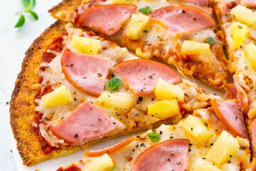

In [14]:
urls = search_images('hawaii pizza', max_images=1)
urls[0]
# download the image and save it in the dest provided
dest = r'.\images\hawaii.jpg'
download_url(urls[0], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'margherita pizza'


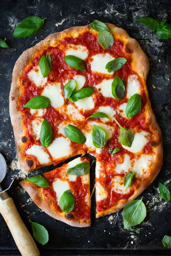

In [15]:
urls = search_images('margherita pizza', max_images=1)
urls[0]
# download the image and save it in the dest provided
dest = r'.\images\margherita.jpg'
download_url(urls[0], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'pepperoni pizza'


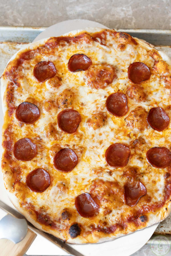

In [16]:
urls = search_images('pepperoni pizza', max_images=1)
urls[0]
# download the image and save it in the dest provided
dest = r'.\images\pepperoni.jpg'
download_url(urls[0], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

In [17]:
searches = 'hawaii','margherita','pepperoni'
path = Path('pizza_classifier')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} pizza'))
    sleep(5)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} pizza homemade'))
    sleep(5)
    download_images(dest, urls=search_images(f'{o} pizza recipe'))
    sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'hawaii pizza'
Searching for 'hawaii pizza homemade'
Searching for 'hawaii pizza recipe'
Searching for 'margherita pizza'
Searching for 'margherita pizza homemade'
Searching for 'margherita pizza recipe'
Searching for 'pepperoni pizza'
Searching for 'pepperoni pizza homemade'
Searching for 'pepperoni pizza recipe'


In [18]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

33

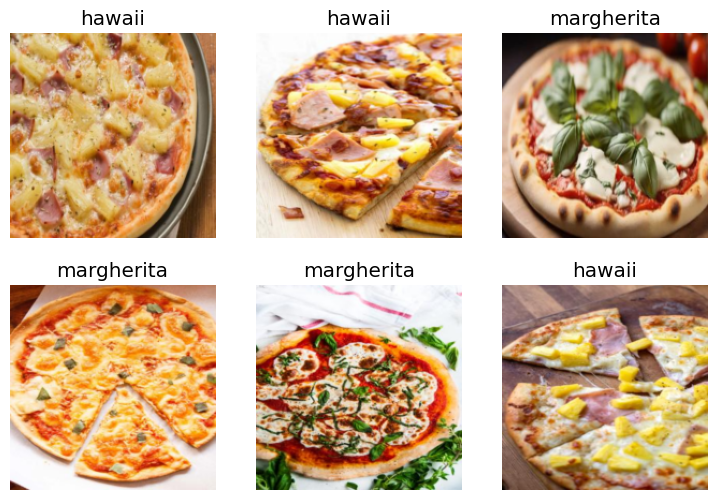

In [19]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [20]:
from fastai.vision.all import vision_learner, resnet18, error_rate
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.743037,2.339069,0.636364,00:16


epoch,train_loss,valid_loss,error_rate,time
0,0.946609,1.023418,0.363636,00:23
1,0.637465,0.777296,0.204545,00:23
2,0.445442,0.664372,0.181818,00:24
3,0.342525,0.621809,0.159091,00:24
4,0.269000,0.600348,0.136364,00:24


In [21]:
is_hawaii,_,probs = learn.predict(PILImage.create(r'.\images\hawaii.jpg'))
print(f"This is a: {is_hawaii}.")
print(f"Probability it's a hawaii: {probs[0]:.4f}")

This is a: hawaii.
Probability it's a hawaii: 0.9633


In [22]:
is_margherita,_,probs = learn.predict(PILImage.create(r'.\images\margherita.jpg'))
print(f"This is a: {is_margherita}.")
print(f"Probability it's a margherita: {probs[1]:.4f}")

This is a: margherita.
Probability it's a margherita: 0.9999


In [23]:
is_pepperoni,_,probs = learn.predict(PILImage.create(r'.\images\pepperoni.jpg'))
print(f"This is a: {is_pepperoni}.")
print(f"Probability it's a pepperoni: {probs[2]:.4f}")

This is a: pepperoni.
Probability it's a pepperoni: 0.9999
